In [7]:
from  scipy.spatial import cKDTree
import pandas as pd
import numpy as np
import os
os.chdir(r'D:\2nd_semester\data_mining\assignment\3')

In [8]:
#Parameter sets for the circles dataset:
#dataset_name = 'circles.csv'
#min_points = [12, 24, 48, 96]
#epsilons = [0.1, 0.2, 0.3]

#Parameter sets for the aniso dataset:
#dataset_name = 'aniso.csv'
#min_points = [12, 24, 48, 96]
#epsilons = [0.2, 0.3, 0.5]

#Parameter sets for the moons dataset:
dataset_name = 'moons.csv'
min_points = [10, 20, 30]
epsilons = [0.07, 0.085, 0.1]

In [9]:
class Data_Points(object):
    def __init__(self, count):
        self.count = count
        self.cluster = -1 
        self.adjacent_points = []
        self.adjacent_points_count = count 

def process_point(points,points_data,point, count,eps):
        point_index = points.index(point) if point in points else -1
        if point_index != -1: 
            points_data[point_index].count += count
            for adjacent_point_index in points_data[point_index].adjacent_points:
                points_data[adjacent_point_index].adjacent_points_count += count
        else:
            point_index = len(points) 
            points.append(point) 
            points_data.append(Data_Points(count))
            tree = cKDTree(points)
            points_data[point_index].adjacent_points = tree.query_ball_point(point, eps)
            for adjacent_point_index in points_data[point_index].adjacent_points:
                if adjacent_point_index != point_index: 
                    points_data[point_index].adjacent_points_count += points_data[adjacent_point_index].count
                    points_data[adjacent_point_index].adjacent_points.append(point_index)
                    points_data[adjacent_point_index].adjacent_points_count += count

In [10]:
def dbscan(dataset, epsilon,min_points):
    points_data = []
    points = []
    clusters = []
    tree = None
    data = [list(i) for i in list(pd.read_csv(dataset, header = None).values)]
    for point in data:
        process_point(points,points_data,point, 1,epsilon)
    num_cluster = -1
    processed_ponts = set()
    for i in range(len(points)):
        if i in processed_ponts:
            continue
        processed_ponts.add(i)
        num_neighbours = points_data[i].adjacent_points_count
        if num_neighbours >= min_points:
            clusters.append({i}) 
            num_cluster = num_cluster + 1
            points_data[i].cluster = num_cluster
            expand_cluster = set(points_data[i].adjacent_points)
            while expand_cluster:
                j = expand_cluster.pop()
                if j not in processed_ponts:
                    processed_ponts.add(j)
                    points_data[j].cluster = num_cluster
                    num_neighbours = points_data[j].adjacent_points_count
                    if num_neighbours >= min_points:
                        expand_cluster |= set(points_data[j].adjacent_points)
        
                if not any([j in c for c in clusters]):
                    points_data[j].cluster = num_cluster
                    clusters[-1].add(j) 
    
    t = []
    for i in clusters:
        for j in i:
            t.append(j)
    t = set(t)
    outlier = []
    for i in range(len(data)):
        if i not in t:
            outlier.append(i)
    
    return clusters,set(outlier)


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
def visualize(dataset,clusters, epsilon, min_points, score, outlier):
    data = np.array([list(i) for i in list(pd.read_csv(dataset, header = None).values)])
    #colors = ['g', 'b', (0,0.33,0.33), 'c', 'm', 'y', 'r',(.6,.6, .6),'k']
    colors = [(0, 0.2, 0.4), 
    (0, 0.6, 0.8),
    (0, 1, 1),
    (0.5, 0, 0), 
    (0.4, 1, 0.6),
    (0, 0.6, 0),
    (0.6, 0.4, 0.2), 
    (0.4, 0.2, 0),
    (1, 1, 0), 
    (1, 0.2, 0), 
    (0.8, 0.6, 1), 
    (0.6, 0.2, 0.4), 
    (0, 0, 0.6), 
    (0.8, 0, 0.6),  
    (0.2, 0.6, 0.4), 
    (1, 0.4, 0.4),]
    ind = 0
    c_map = ['k' for i in range(len(data))]
    for i in clusters:
        for j in i:
            c_map[j] = colors[ind]
        ind += 1
    for i in outlier:
        c_map[i] = (0,0,0)

    plt.figure(figsize=(8, 6))
    plt.scatter(data[:,0], data[:,1], c=c_map)
    plt.suptitle('epsilon: {}, min_points: {}, cluster: {}, silhouette: {}'.format(epsilon,min_points,len(clusters),score),
                 fontsize=20)

In [12]:
import math

def eucledian_distance(x1,y1,x2,y2):
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)

# Search point within cluster

In [13]:
def search(point,cluster):
    ind = 0
    for i in cluster:
        if point in i:
            return ind
        ind += 1
    return -1

# Mean Intra-Cluster Distance(a)

In [14]:
def a(point, clusters, dataset):
    data = np.array([list(i) for i in list(pd.read_csv(dataset, header = None).values)])
    a = 0
    ind = search(point, clusters)
    for i in clusters[ind]:
        if i == point:
            continue
        a += eucledian_distance(data[point][0],data[point][1],data[i][0],data[i][1])
    denom = (len(clusters[ind]) - 1)
    return a / denom

# Mean nearest-cluster distance (b) for each sample Calculation

In [15]:
#the mean nearest-cluster distance (b) for each sample
def b(point, clusters, dataset):
    data = np.array([list(i) for i in list(pd.read_csv(dataset, header = None).values)])
    no_clusters = len(clusters) 
    b= []
    ind = search(point,clusters)
    for i in range(no_clusters):
        if i == ind: continue # if current cluster then continue
        temp = 0
        for j in clusters[i]:
            temp += eucledian_distance(data[point][0],data[point][1],data[j][0],data[j][1])
        b.append(temp/len(clusters[i]))
    if not b: return 0
    return min(b) 

In [16]:
def silhouette(point, clusters, dataset):
    ind = search(point, clusters)
    s = 0
    if len(clusters[ind]) == 1:
        s = 0
    else:
        b_val = b(point,clusters,dataset)
        a_val = a(point,clusters,dataset)            
        s = (b_val - a_val) / max([a_val,b_val])
    return s

In [17]:
def sc_all_points(clusters, dataset):
    data = np.array([list(i) for i in list(pd.read_csv(dataset, header = None).values)])
    mean_si = 0
    count = 0
    for i in range(len(data)):
            count += 1
            mean_si += silhouette(i, clusters, dataset)
    return mean_si/count

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
def run_parameter_search(dataset_name, min_points, epsilons):
    clusters = []
    outlier = {}
    scores = {}
    s = 0
    for epsilon in epsilons:
        for min_point in min_points:
            clusters,outlier = dbscan(dataset_name, epsilon,min_point)
            if len(clusters) >= 2:
                s = sc_all_points(clusters[:len(clusters)],dataset_name)
                if len(clusters) in scores:
                    scores[len(clusters)].append(s)
                else:
                    scores[len(clusters)] = list()
                    scores[len(clusters)].append(s)
            if len(clusters) < 2:
                s = "Not defined"
            visualize(dataset_name,clusters,epsilon,min_point,s,outlier)
    x = list(scores.keys())
    y = [tuple(i) for i in scores.values()]
    plt.figure(figsize=(8, 6))
    for xi,yi in zip(x,y):
        plt.scatter([xi]*len(yi),yi) 
    plt.suptitle(dataset_name, fontsize=20)
    plt.xlabel('K', fontsize=18)
    plt.ylabel('Silhouette', fontsize=16)
    return scores

{2: [0.11451918017385444, 0.11412698720958252, 0.11412698720958252],
 13: [-0.1259363654647651],
 3: [-0.16984805009395706],
 9: [0.11012801244035653]}

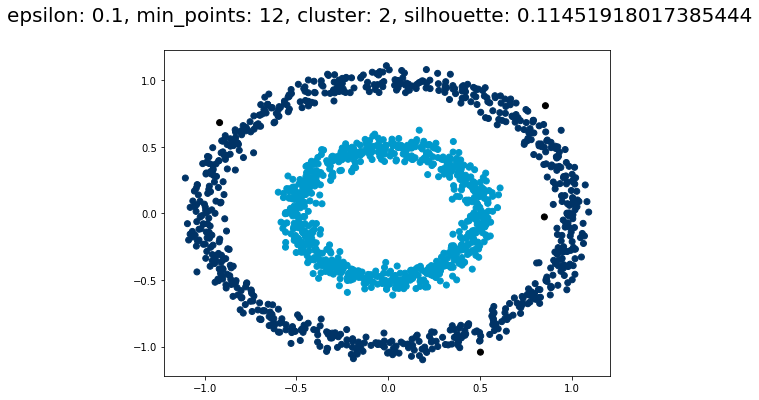

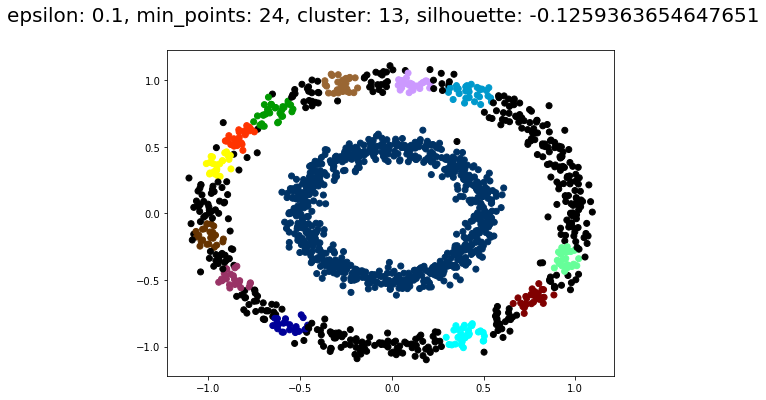

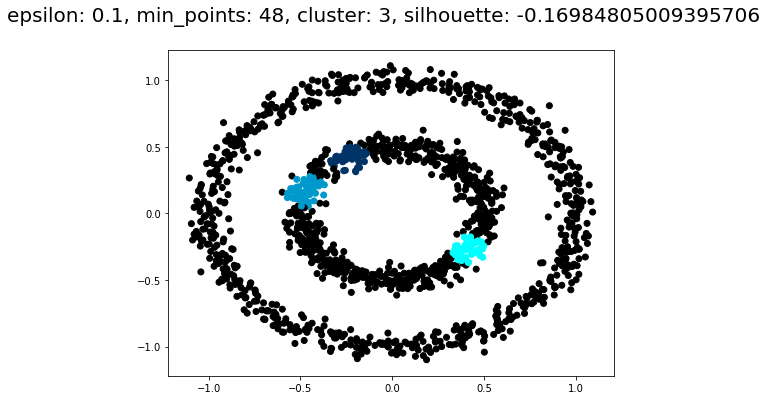

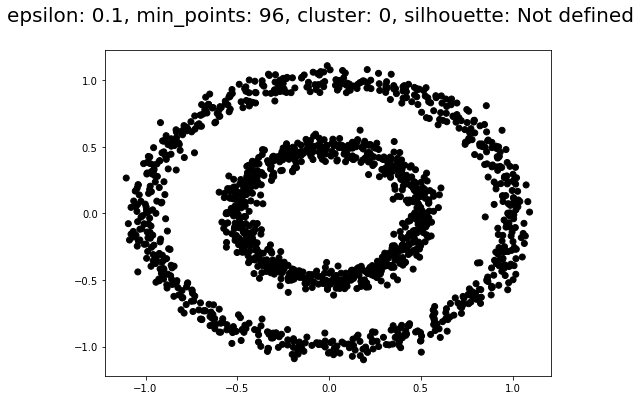

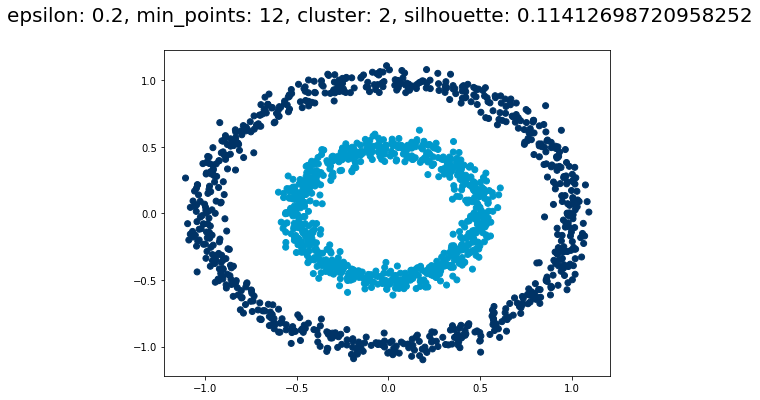

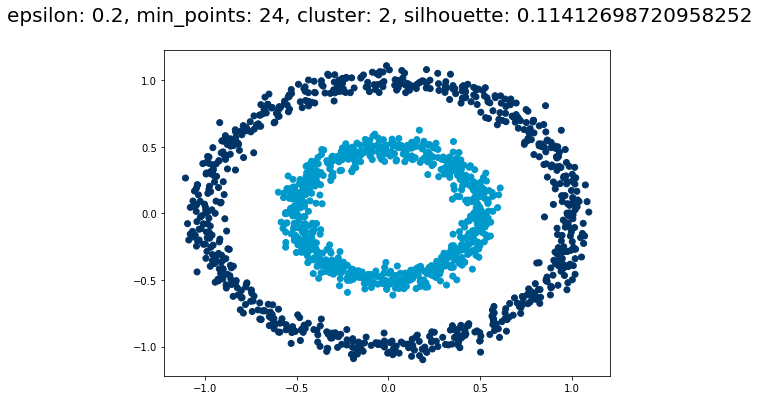

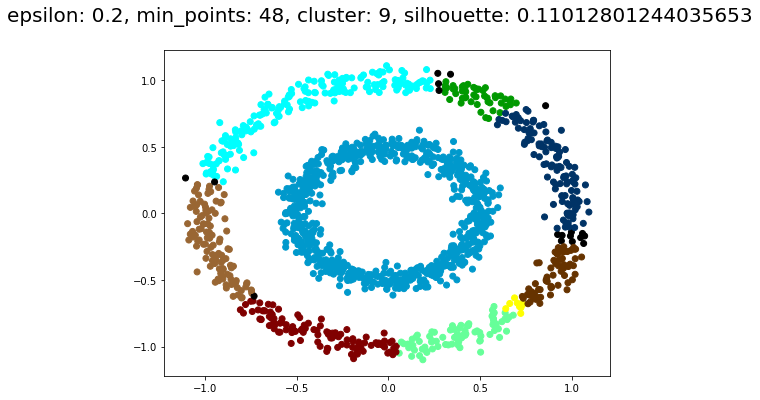

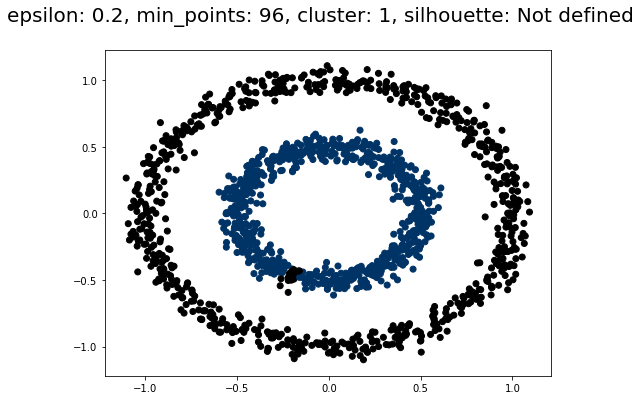

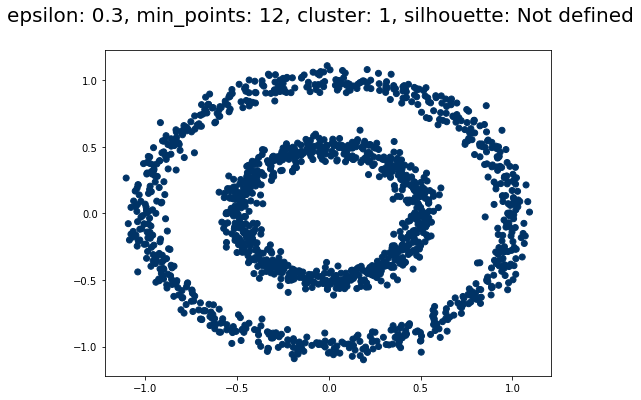

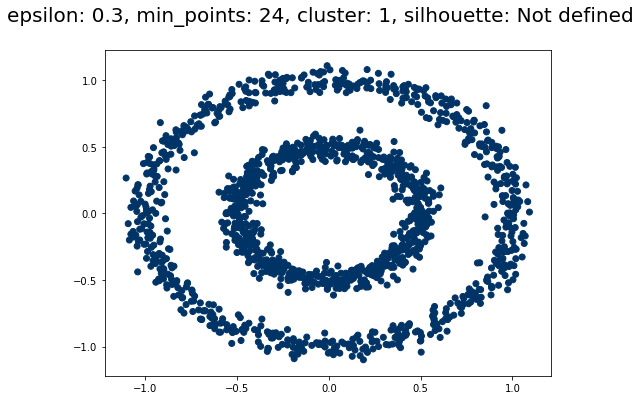

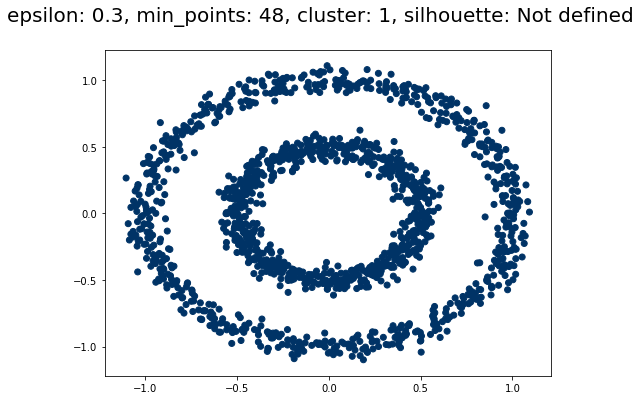

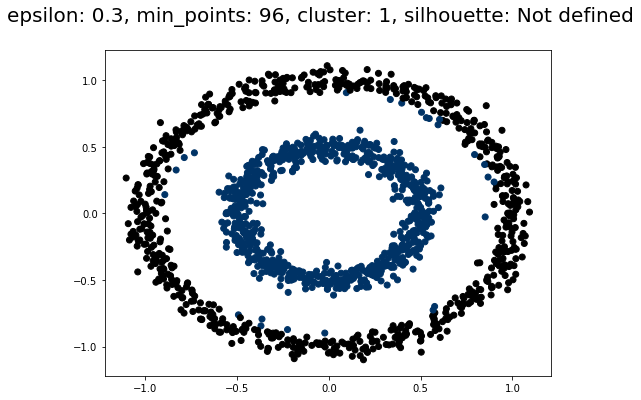

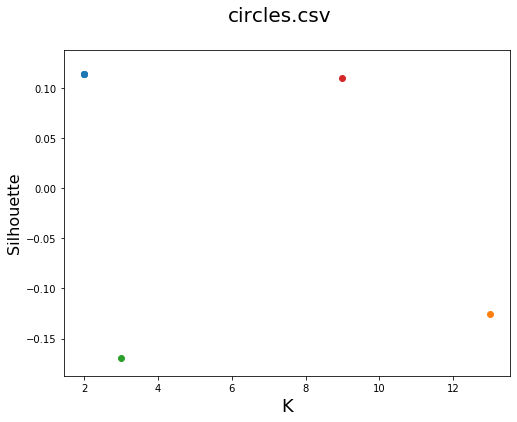

In [43]:
run_parameter_search(dataset_name, min_points, epsilons)

{3: [0.4598818441066988,
  0.3551882768705105,
  0.47328732804071866,
  0.4786546762503277,
  0.38986536758564316,
  0.48080272535824464,
  0.4397276339263945],
 2: [0.6274284034386921]}

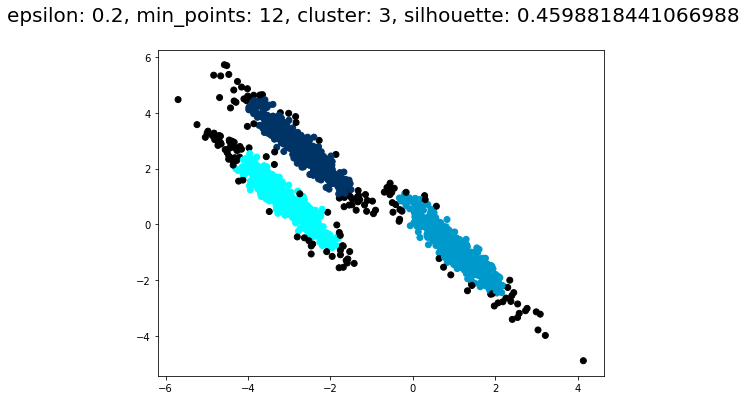

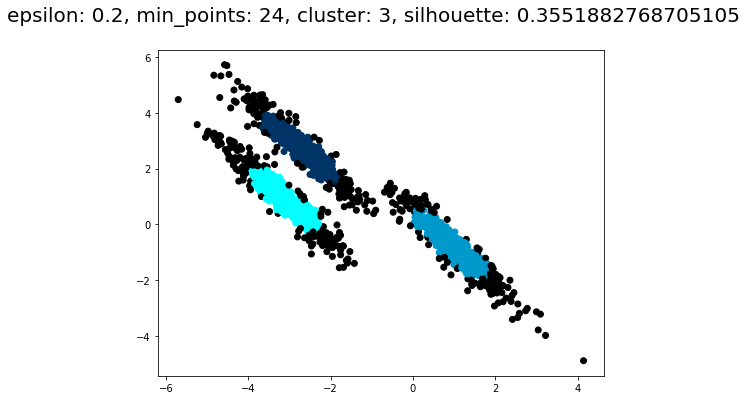

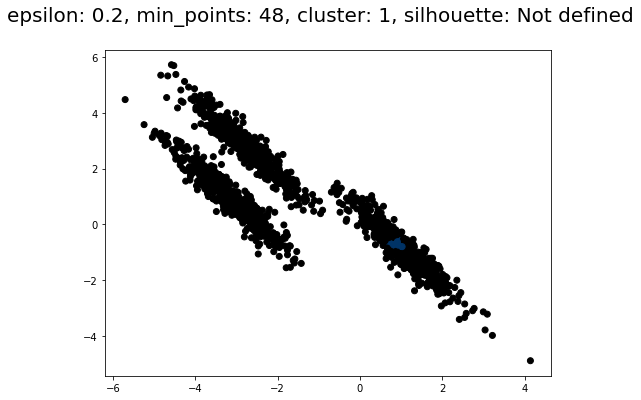

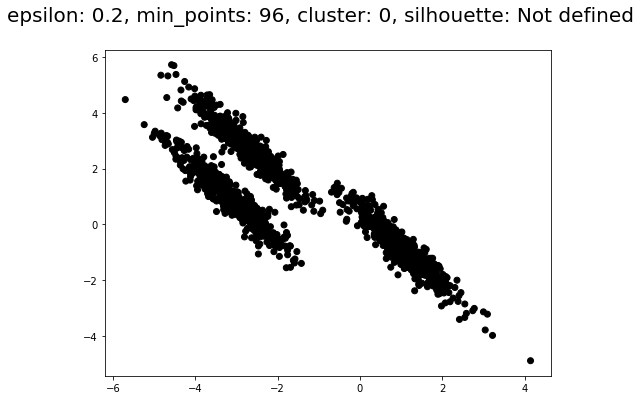

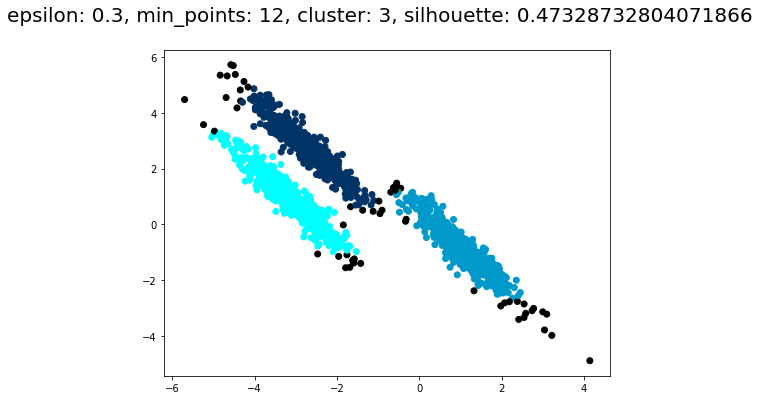

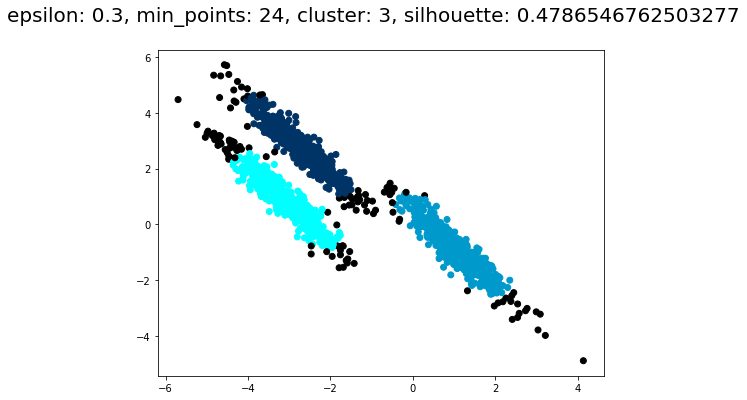

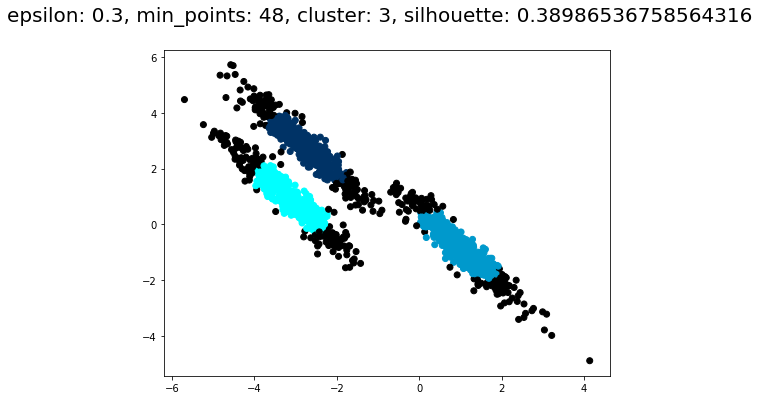

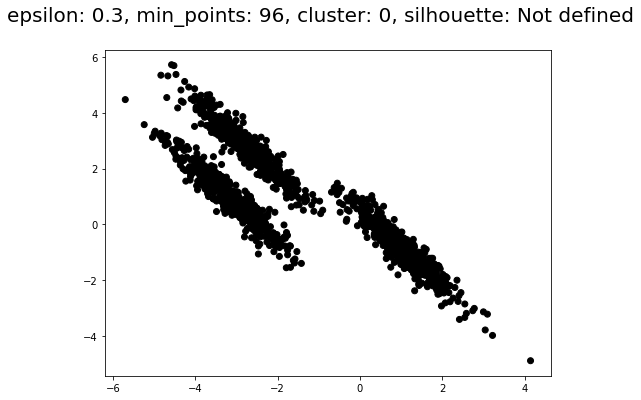

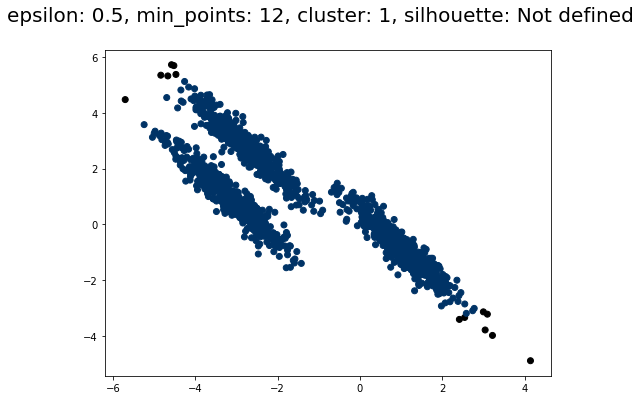

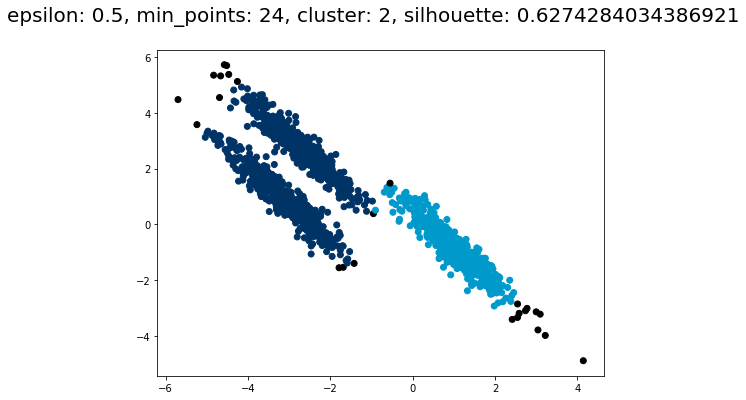

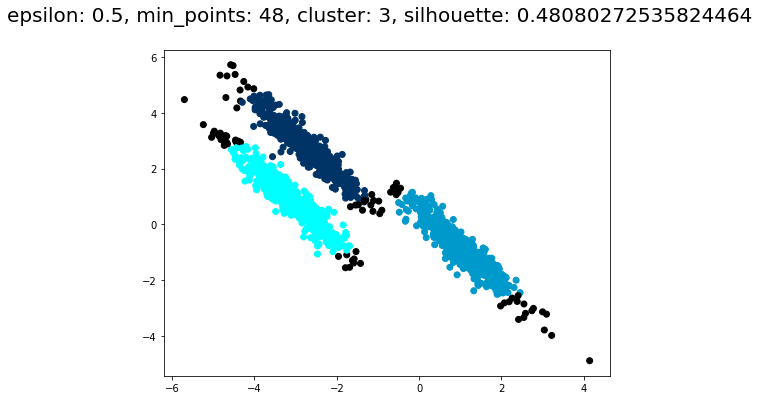

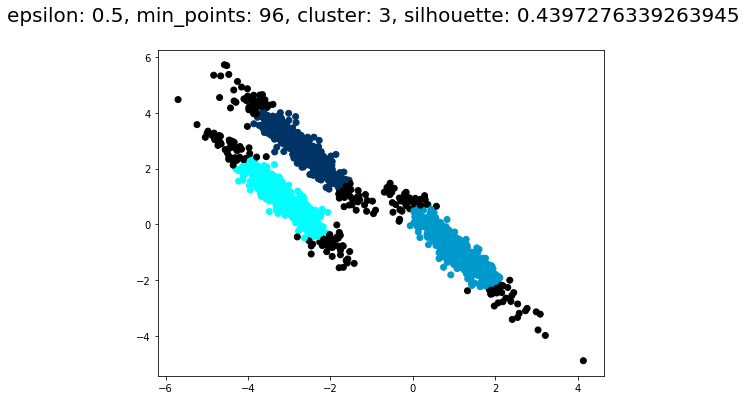

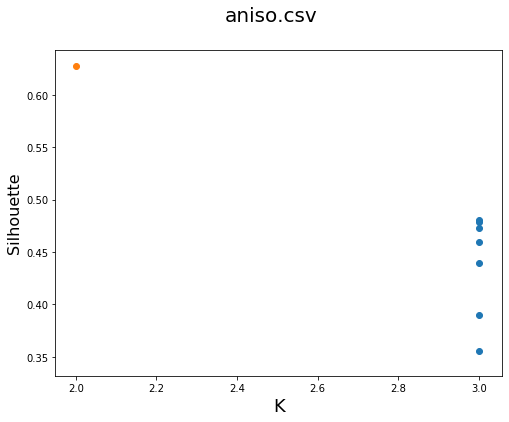

In [45]:
run_parameter_search(dataset_name, min_points, epsilons)

{2: [0.3295997416854929,
  0.3324112863656764,
  0.3338058088316047,
  0.33357553297632386,
  0.333010065175729,
  0.3358337343315266],
 4: [0.37322035312540525],
 5: [-0.3355072168024573],
 8: [0.26701862872957716]}

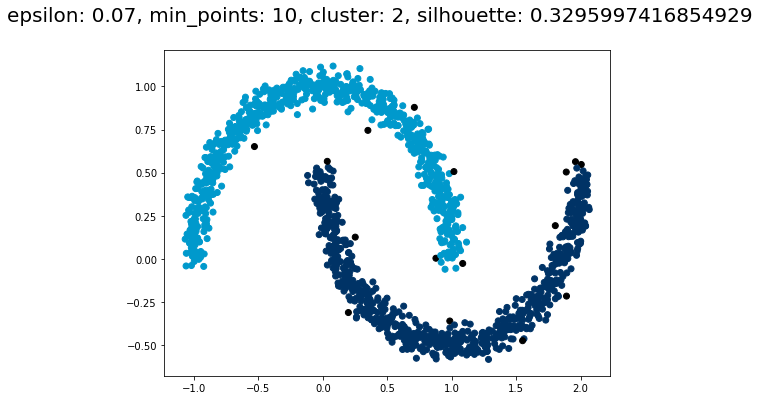

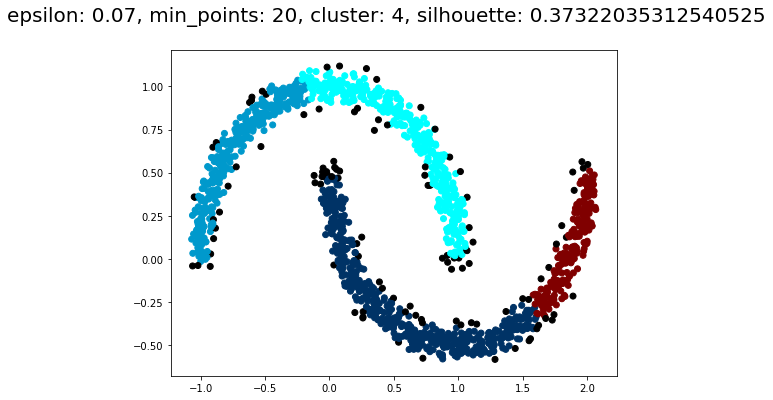

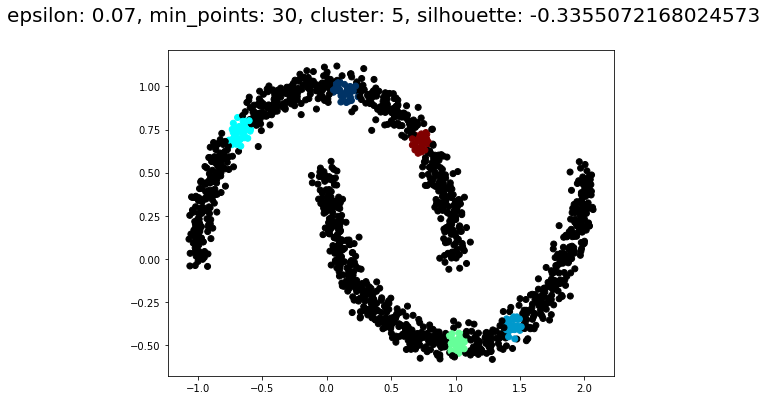

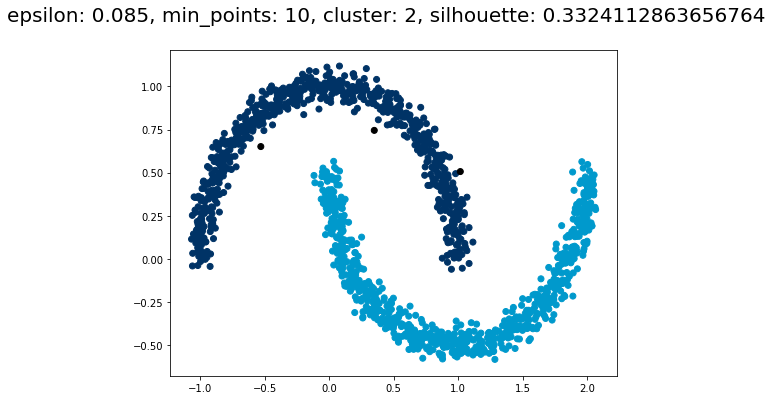

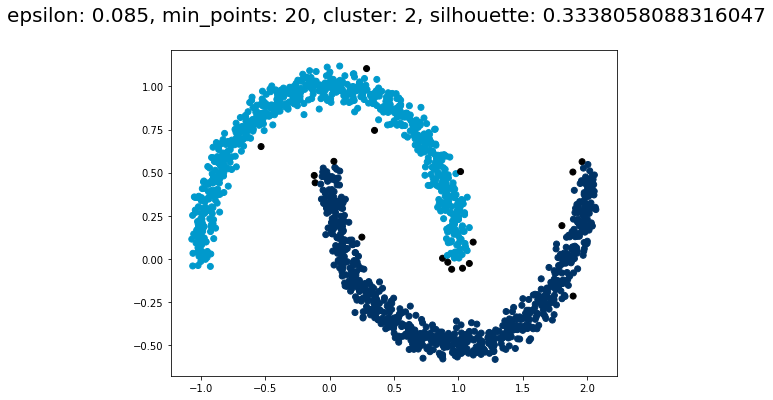

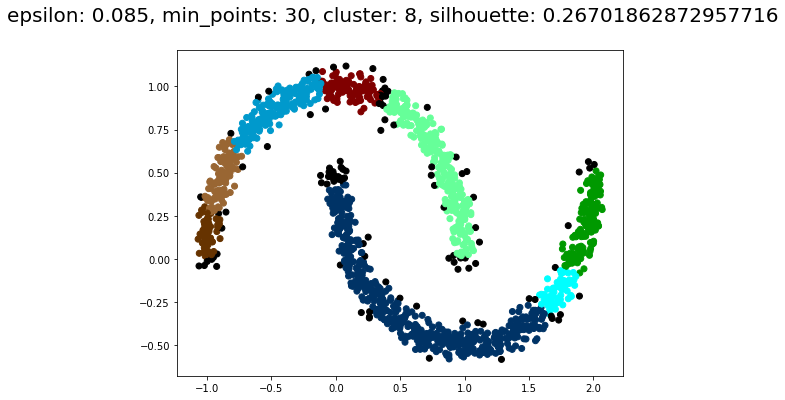

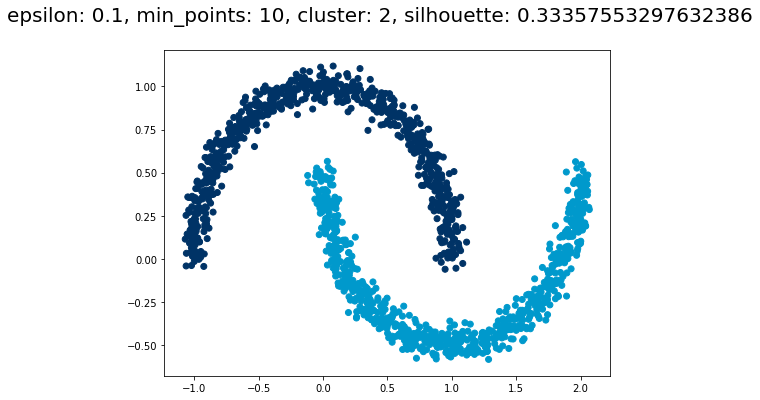

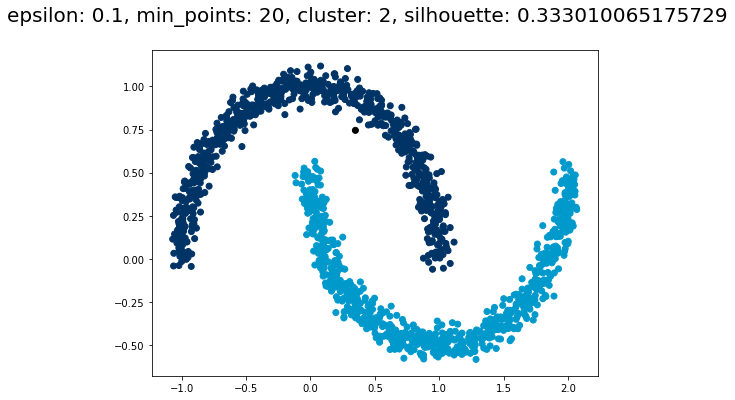

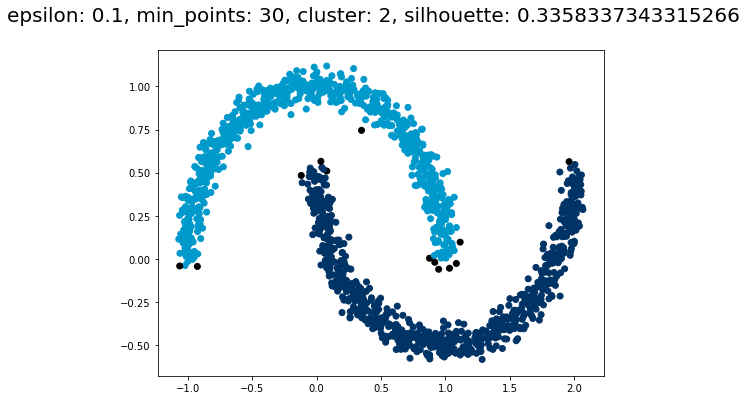

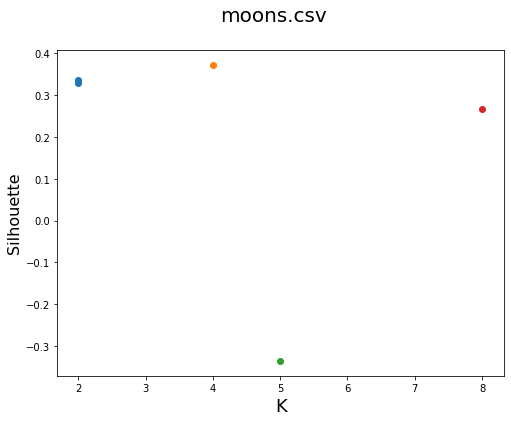

In [47]:
run_parameter_search(dataset_name, min_points, epsilons)